# Overfitting y Regularización 

In [ ]:
#!unzip mnist.zip

In [3]:
import numpy as np 
import matplotlib.pyplot as plt

In [4]:
from glob import glob

In [5]:
train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/1/6783.png'

In [6]:
test_files[0]

'./mnist/test/1/725.png'

In [7]:
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

In [8]:
from PIL import Image
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [9]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [10]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [11]:
len(X_train), len(X_valid), len(X_test)

(6000, 2000, 992)

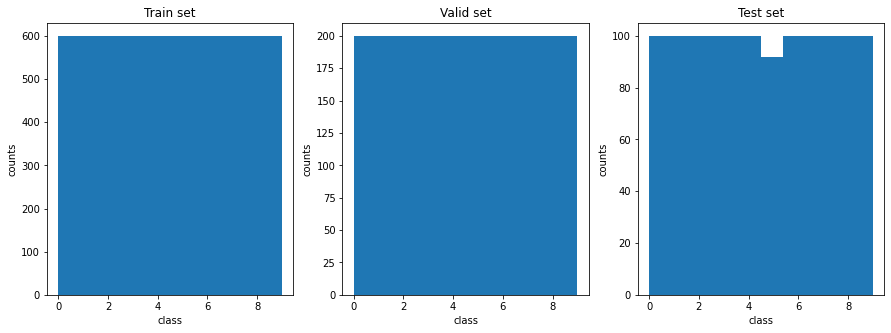

In [12]:
#--- Visualizamos la distribución de clases en cada subset
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

In [13]:
import torch
input_dim = 28*28
output_dim = 10
hidden = 60

model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden,hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden,hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden,hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden,output_dim)
)
model


Sequential(
  (0): Linear(in_features=784, out_features=60, bias=True)
  (1): ReLU()
  (2): Linear(in_features=60, out_features=60, bias=True)
  (3): ReLU()
  (4): Linear(in_features=60, out_features=60, bias=True)
  (5): ReLU()
  (6): Linear(in_features=60, out_features=60, bias=True)
  (7): ReLU()
  (8): Linear(in_features=60, out_features=10, bias=True)
)

In [14]:

#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [15]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

In [24]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  #CM(Y_valid, Y_pred, 10)

  0%|          | 0/1 [00:00<?, ?it/s]

ne: 50, hd:20, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 1.7122598886489868. f1:0.37266323906567206 acc: 0.4205000102519989 


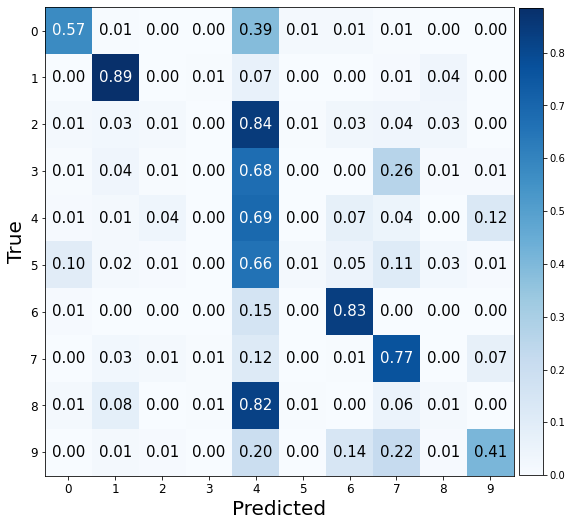

###################

ne: 50, hd:20, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6626107096672058. f1:0.7925690949676585 acc: 0.7919999957084656 


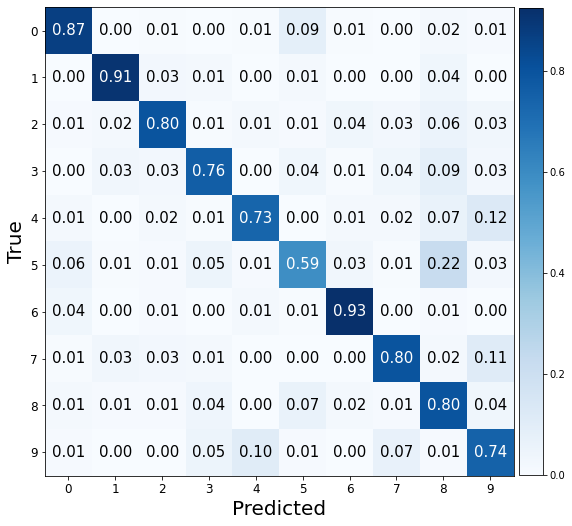

###################



In [42]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm

hd_list = [20]

#Número de epocas 
ne_list = [50]
#Learning rate
lr_list = [0.001,]
#Weight decay
wd_list = [0.001]
#Batch size 
bs_list = [256]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))


#--- Se definen los dos modelos a probar
input_dim = 28*28
out_dim = 10
def models(index,hidden):
  if index==0:
    model = torch.nn.Sequential(
      torch.nn.Linear(input_dim, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, out_dim)
    )

  if index==1:
    model = torch.nn.Sequential(
      torch.nn.Linear(input_dim, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, out_dim)
    )
  return model

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          hidden = hd
          for i in range(2):
            model = models(i,hidden)

            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            criterion = torch.nn.CrossEntropyLoss()

            print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
            train_valid(model,ne,optimizer,criterion)
            print('###################\n')

          pbar.update()
pbar.close()


In [28]:
models

[Sequential(
   (0): Linear(in_features=784, out_features=20, bias=True)
   (1): ReLU()
   (2): Linear(in_features=20, out_features=10, bias=True)
 ), Sequential(
   (0): Linear(in_features=784, out_features=20, bias=True)
   (1): ReLU()
   (2): Linear(in_features=784, out_features=20, bias=True)
   (3): ReLU()
   (4): Linear(in_features=784, out_features=20, bias=True)
   (5): ReLU()
   (6): Linear(in_features=20, out_features=10, bias=True)
 )]